In [1]:
import sys
print(sys.executable)


/home/alfrizz/.venvs/StockAnalysis/bin/python3


In [2]:
import math
import pandas as pd
from pandas import Timestamp
import numpy as np
import glob
import os
import datetime as dt
from datetime import datetime
from pprint import pprint
from collections import OrderedDict

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.display import display, HTML

from typing import List, Sequence, Tuple
from sklearn.preprocessing import StandardScaler

import importlib
import stockanalibs
importlib.reload(stockanalibs)

from tqdm.auto import tqdm
tqdm.pandas()        

pd.set_option('display.max_columns', None)

display(HTML("""
<style>
.output_scroll {
    overflow-y: visible !important;
    max-height: none !important;
}
</style>
"""))


/home/alfrizz/.venvs/StockAnalysis/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
ticker = stockanalibs.ticker
folder = "Intraday stocks" 

bidasktoclose_spread = 0.03

date_to_check = None
date_to_check = '2021-07' # if 'None' (just comment this line) all dates to be analyzed and final merged CSV to be saved

dfs training/GOOGL_base.csv already exists. Reading and plotting the processed data...


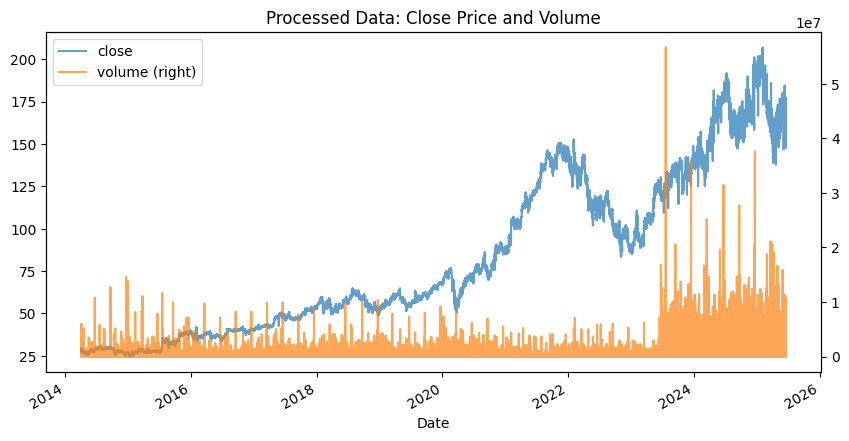

reference_gain 0.021259211873474328


open      high       low     close   volume  \
datetime                                                               
2014-04-03 10:42:00   28.6500   28.6500   28.6500   28.6500   2000.0   
2014-04-03 10:43:00   28.6500   28.6500   28.6500   28.6500   2000.0   
2014-04-03 11:04:00   28.6500   28.6500   28.6500   28.6500  11220.0   
2014-04-03 11:05:00   28.6500   28.6500   28.6500   28.6500   4620.0   
2014-04-03 11:34:00   28.5005   28.5005   28.5005   28.5005   3460.0   
...                       ...       ...       ...       ...      ...   
2025-06-18 23:55:00  173.9000  173.9445  173.8670  173.8681   3136.0   
2025-06-18 23:56:00  173.8200  173.9500  173.7900  173.9000    183.0   
2025-06-18 23:57:00  173.9500  173.9500  173.8600  173.8601    240.0   
2025-06-18 23:58:00  173.8600  173.9000  173.8600  173.8600    327.0   
2025-06-18 23:59:00  173.8700  173.8700  173.8600  173.8700    124.0   

                            ask         bid  
datetime                                     
2014-04-03 10:42:00   28.658595   28.641405  
2014-04-03 10:43:00   28.658595   28.641405  
2014-04-03 11:04:00   28.658595   28.641405  
2014-04-03 11:05:00   28.658595   28.641405  
2014-04-03 11:34:00   28.509050   28.491950  
...                         ...         ...  
2025-06-18 23:55:00  173.920300  173.815900  
2025-06-18 23:56:00  173.952200  173.847800  
2025-06-18 23:57:00  173.912300  173.807900  
2025-06-18 23:58:00  173.912200  173.807800  
2025-06-18 23:59:00  173.922200  173.817800  

[1462494 rows x 7 columns]

In [4]:
# first process of the dataframe, adding artificial bid and ask prices, and correcting possible price splits

df = stockanalibs.process_splits(folder=folder, 
                                ticker=ticker, 
                                bidasktoclose_spread=bidasktoclose_spread,
                                vol_fact=1)

reference_gain = stockanalibs.compute_reference_gain(df)

print('reference_gain', reference_gain)

df

In [5]:

def aggregate_performance(perf_list, round_digits=3):
    """
    Given a list of daily performance dictionaries, aggregate them as follows:
      - For numeric keys, sum their values and round the result.
      - For list keys (like "Trade Gains ($)" and "Trade Gains (%)"), replace them
        with a message indicating the number of trades.
    Then update:
      - "Strategy Profit Difference ($)" = "Final Net Value ($)" - "Buy & Hold Gain ($)"
      - "Strategy Improvement (%)"    = "Final Net Return (%)" - "Buy & Hold Return (%)"
    Returns the aggregated performance dictionary.
    """
    aggregated = {}
    keys = set()
    for perf in perf_list:
        if perf is not None:
            keys.update(perf.keys())
    for key in keys:
        if key in ["Trade Gains ($)", "Trade Gains (%)"]:
            temp_list = []
            for perf in perf_list:
                if perf and key in perf and isinstance(perf[key], list):
                    temp_list.extend(perf[key])
            aggregated[key] = f"{len(temp_list)} trades"
        else:
            total = 0
            for perf in perf_list:
                if perf and key in perf and isinstance(perf[key], (int, float)):
                    total += perf[key]
            aggregated[key] = round(total, round_digits)
    if "Final Net Value ($)" in aggregated and "Buy & Hold Gain ($)" in aggregated:
        aggregated["Strategy Profit Difference ($)"] = round(
            aggregated["Final Net Value ($)"] - aggregated["Buy & Hold Gain ($)"], round_digits)
    if "Final Net Return (%)" in aggregated and "Buy & Hold Return (%)" in aggregated:
        aggregated["Strategy Improvement (%)"] = round(
            aggregated["Final Net Return (%)"] - aggregated["Buy & Hold Return (%)"], round_digits)
    return aggregated



In [6]:

def saveDF_checkDAY(
    df,
    ticker,
    min_prof_thr,
    max_down_prop,
    gain_tightening_factor,
    smooth_win_sig,
    pre_entry_decay,
    buy_threshold,
    trailing_stop_thresh,
    merging_retracement_thr,
    merging_time_gap_thr,
    reference_gain,
    keep_cols=None,
    date_to_check=None
):
    """
    Modes:
      • Month ('YYYY-MM')   → process each day, then summary  
      • Day   ('YYYY-MM-DD')→ process that day only  
      • None  → full‐run: smooth ALL, pipeline, merge+interpolate w/ progress, save CSV  
    """
    if keep_cols is None:
        keep_cols = [
            "open","high","low","close","volume",
            "bid","ask","trade_action",
            "StrategyEarning","EarningDiff","signal_smooth"
        ]

    performance_list = []

    # -------------------------------------------------------------------------
    # Process exactly one calendar day
    # -------------------------------------------------------------------------
    def process_single_day(day_str):
        print(f"\n=== Processing trading day {day_str} ===")
        day_dt = pd.to_datetime(day_str)
        day_df = df.loc[df.index.normalize() == day_dt].copy()
        if day_df.empty:
            print(" no data; skipping.")
            return

        try:
            day_df_prep = stockanalibs.prepare_interpolate_data(
                df=day_df,
                regular_start=stockanalibs.regular_start,
                regular_end=stockanalibs.regular_end
            )
        except ValueError as ve:
            if "window 0" in str(ve):
                print(" warning: smoothing window=0; skipping smoothing.")
            else:
                raise

        result = stockanalibs.run_trading_pipeline(day_df_prep, reference_gain, day_to_check=day_str)
        if result is None:
            print(" no trades found; skipping.")
            return

        df_day, trades_day, perf_day = result
        stockanalibs.plot_trades(
            df=df_day,
            trades=trades_day,
            buy_threshold=buy_threshold,
            performance_stats=perf_day
        )
        plt.show(block=False)
        plt.close()

        performance_list.append(perf_day)
        order = [
            "Final Net Value ($)", "Buy & Hold Gain ($)",
            "Strategy Profit Difference ($)", "Final Net Return (%)",
            "Buy & Hold Return (%)", "Strategy Improvement (%)",
            "Trade Gains ($)", "Trade Gains (%)"
        ]
        summary = OrderedDict()
        for key in order:
            if key in perf_day:
                val = perf_day[key]
                summary[key] = round(val, 3) if isinstance(val, (int, float)) else val

        print(" Daily Performance:")
        for k, v in summary.items():
            print(f"   {k}: {v}")

    # -------------------------------------------------------------------------
    # Main dispatch logic
    # -------------------------------------------------------------------------
    if date_to_check:
        # Month mode: 'YYYY-MM'
        if len(date_to_check) == 7:
            print(f"\nMonth mode: processing {date_to_check}")
            days = (
                df.loc[df.index.strftime("%Y-%m") == date_to_check]
                  .index.normalize()
                  .unique()
            )
            for d in sorted(days.astype(str)):
                process_single_day(d)

            monthly_summary = aggregate_performance(performance_list)
            print(f"\nFinal Summary for month {date_to_check}:")
            pprint(monthly_summary)
            return None

        # Single-day mode: 'YYYY-MM-DD'
        else:
            return process_single_day(date_to_check)

    # -------------------------------------------------------------------------
    # Full-run mode (date_to_check=None)
    # -------------------------------------------------------------------------
    print(f"\nFull-run mode: started at {datetime.now():%H:%M:%S}")
    print(" Step A: smoothing & DST adjust …")
    df_prep = stockanalibs.prepare_interpolate_data(
        df=df,
        regular_start=stockanalibs.regular_start,
        regular_end=stockanalibs.regular_end
    )

    print(" Step B: running trading pipeline on full dataset …")
    full_sim_results = stockanalibs.run_trading_pipeline(df_prep, reference_gain, day_to_check=None)

    print(" Step C: merging & interpolating all days …")
    # merged = merge_and_interpolate(full_sim_results)   # <— here
    daily_frames = [triple[0][keep_cols] for triple in full_sim_results.values()]
    merged = pd.concat(daily_frames).sort_index()

    print(" Step D: saving CSV …")
    out_path = f"dfs training/{ticker}_final.csv"
    merged.to_csv(out_path)
    print(f"Saved to {out_path} at {datetime.now():%H:%M:%S}")

    return merged




Month mode: processing 2021-07

=== Processing trading day 2021-07-01 ===


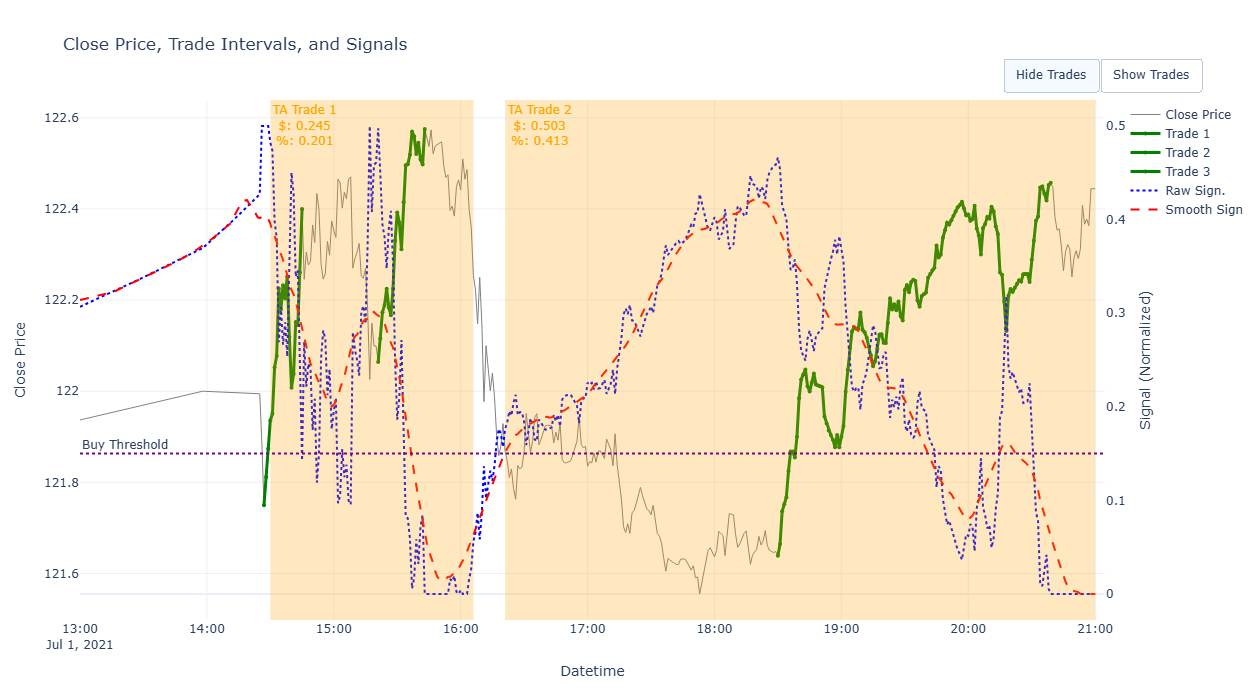

 Daily Performance:
   Final Net Value ($): 0.748
   Buy & Hold Gain ($): 0.436
   Strategy Profit Difference ($): 0.312
   Final Net Return (%): 0.613
   Buy & Hold Return (%): 0.357
   Strategy Improvement (%): 0.256
   Trade Gains ($): [np.float64(0.245), np.float64(0.503)]
   Trade Gains (%): [np.float64(0.201), np.float64(0.413)]

=== Processing trading day 2021-07-02 ===


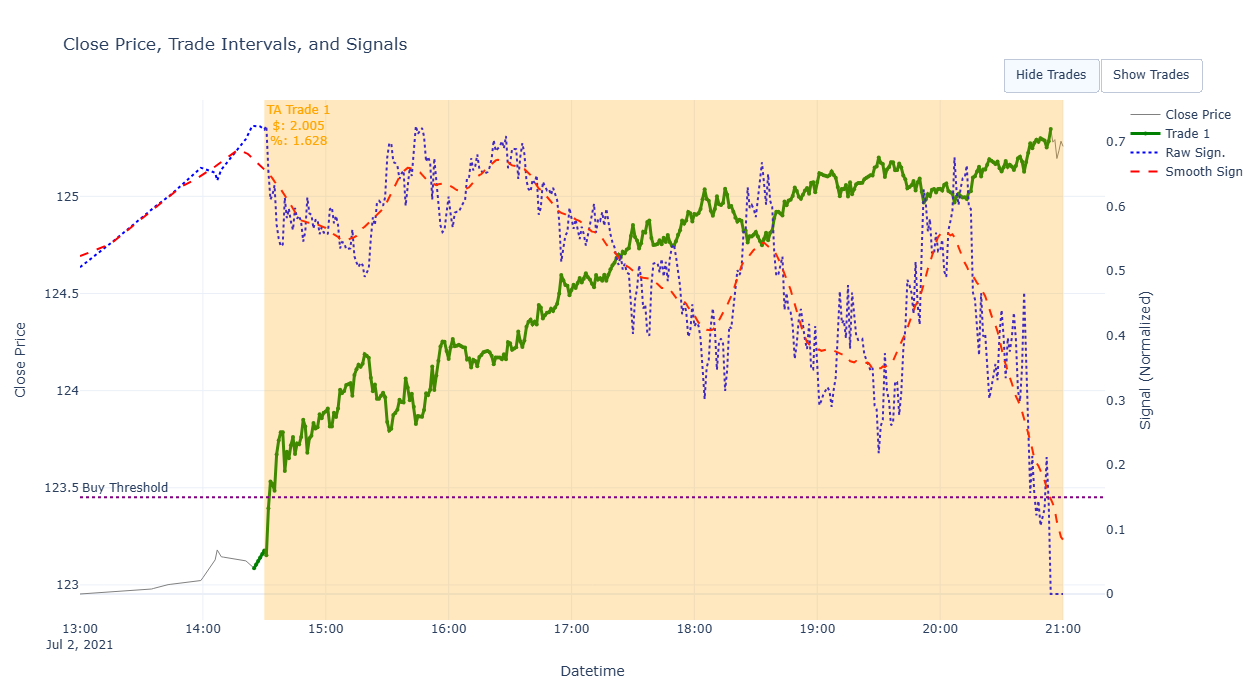

 Daily Performance:
   Final Net Value ($): 2.032
   Buy & Hold Gain ($): 2.032
   Strategy Profit Difference ($): 0.0
   Final Net Return (%): 1.649
   Buy & Hold Return (%): 1.649
   Strategy Improvement (%): 0.0
   Trade Gains ($): [np.float64(2.005)]
   Trade Gains (%): [np.float64(1.628)]

=== Processing trading day 2021-07-06 ===


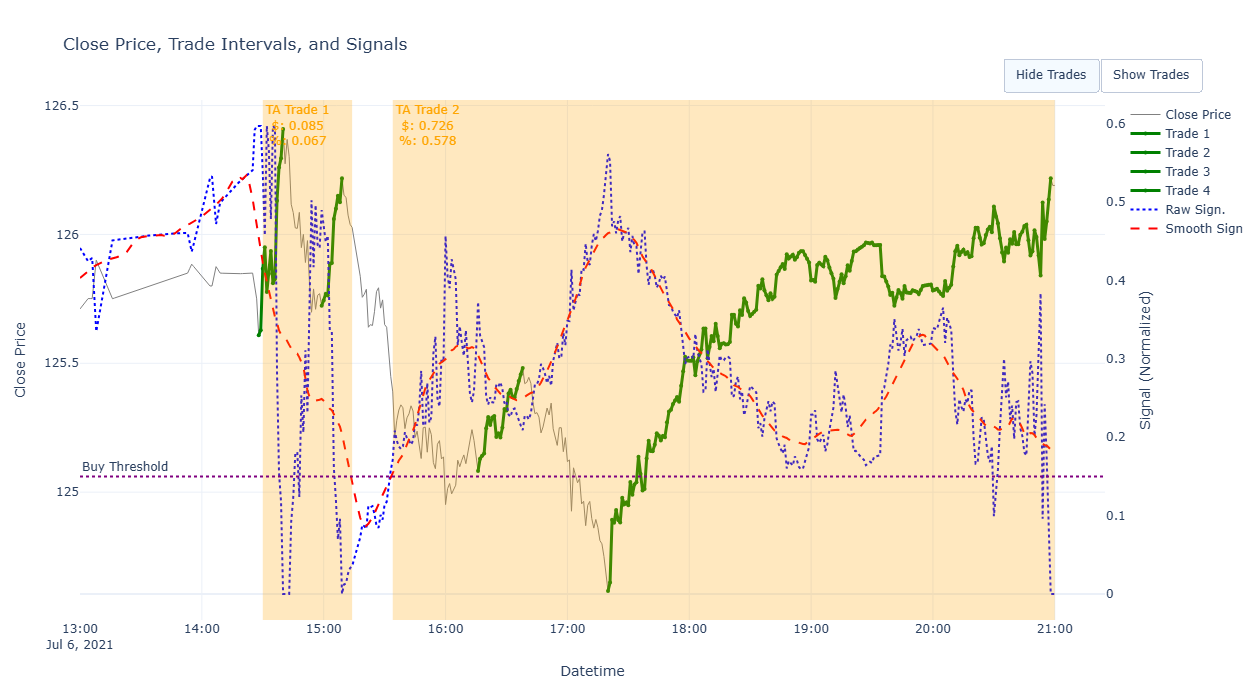

 Daily Performance:
   Final Net Value ($): 0.81
   Buy & Hold Gain ($): 0.248
   Strategy Profit Difference ($): 0.562
   Final Net Return (%): 0.643
   Buy & Hold Return (%): 0.197
   Strategy Improvement (%): 0.446
   Trade Gains ($): [np.float64(0.085), np.float64(0.726)]
   Trade Gains (%): [np.float64(0.067), np.float64(0.578)]

=== Processing trading day 2021-07-07 ===


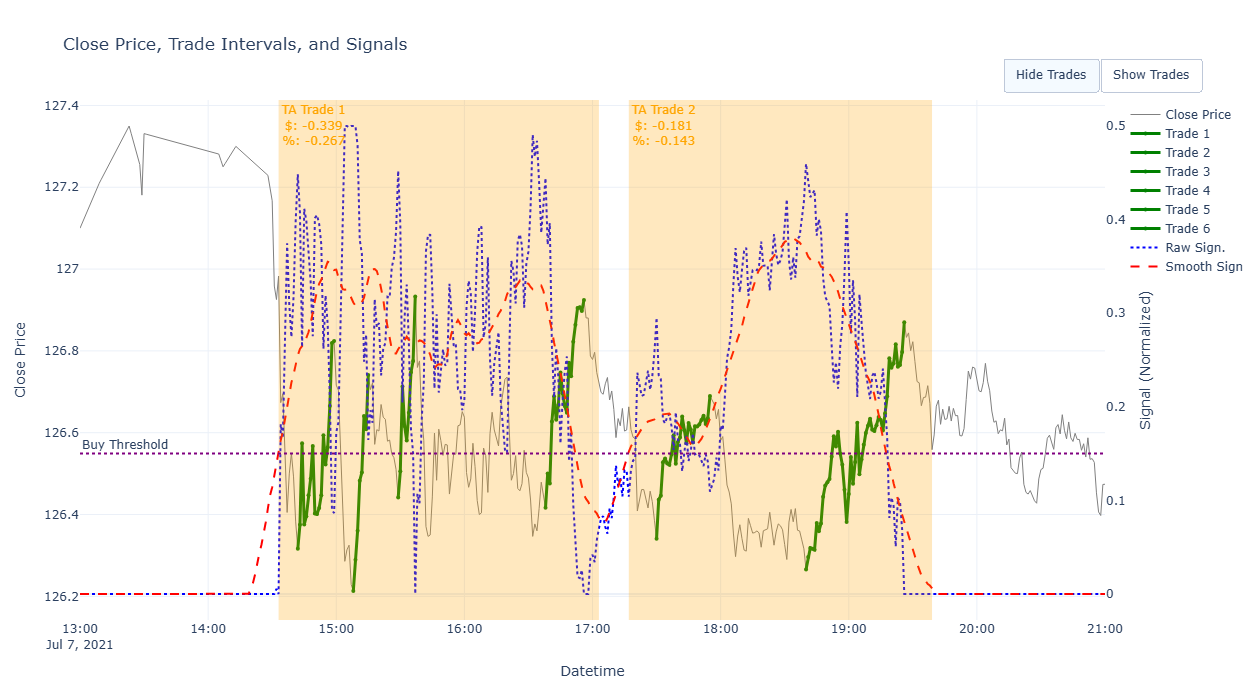

 Daily Performance:
   Final Net Value ($): -0.519
   Buy & Hold Gain ($): -0.77
   Strategy Profit Difference ($): 0.251
   Final Net Return (%): -0.408
   Buy & Hold Return (%): -0.605
   Strategy Improvement (%): 0.197
   Trade Gains ($): [np.float64(-0.339), np.float64(-0.181)]
   Trade Gains (%): [np.float64(-0.267), np.float64(-0.143)]

=== Processing trading day 2021-07-08 ===


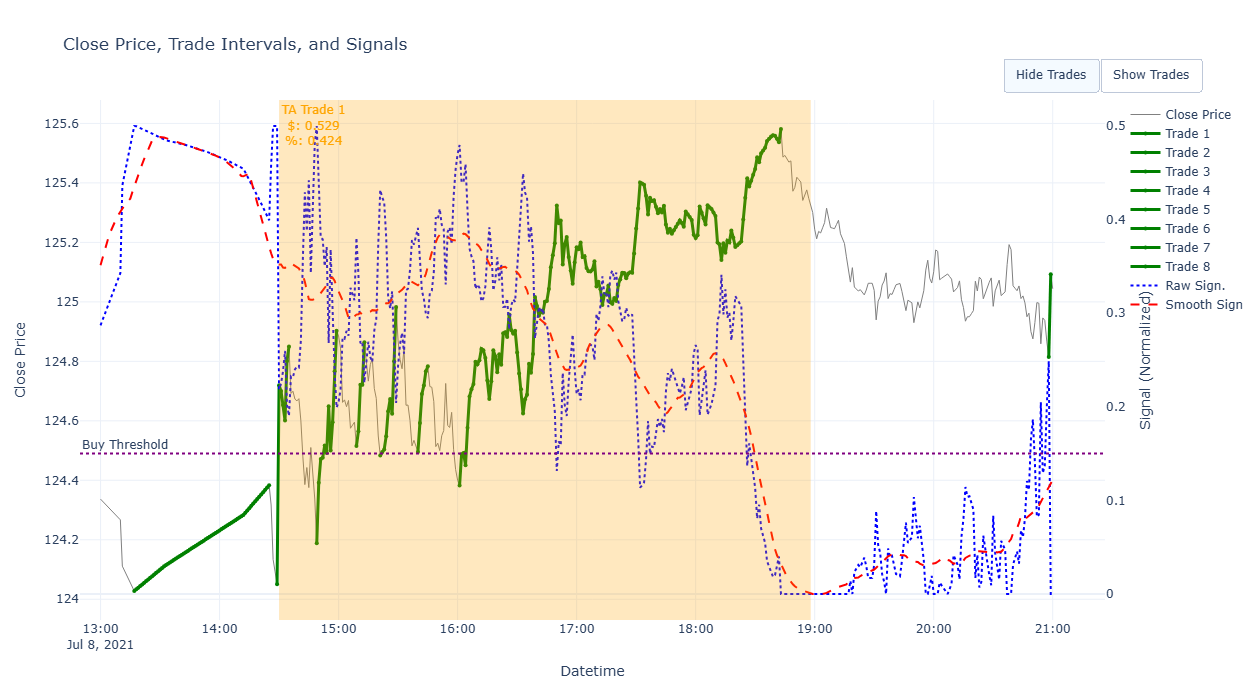

 Daily Performance:
   Final Net Value ($): 0.529
   Buy & Hold Gain ($): 0.298
   Strategy Profit Difference ($): 0.231
   Final Net Return (%): 0.424
   Buy & Hold Return (%): 0.239
   Strategy Improvement (%): 0.186
   Trade Gains ($): [np.float64(0.529)]
   Trade Gains (%): [np.float64(0.424)]

=== Processing trading day 2021-07-09 ===


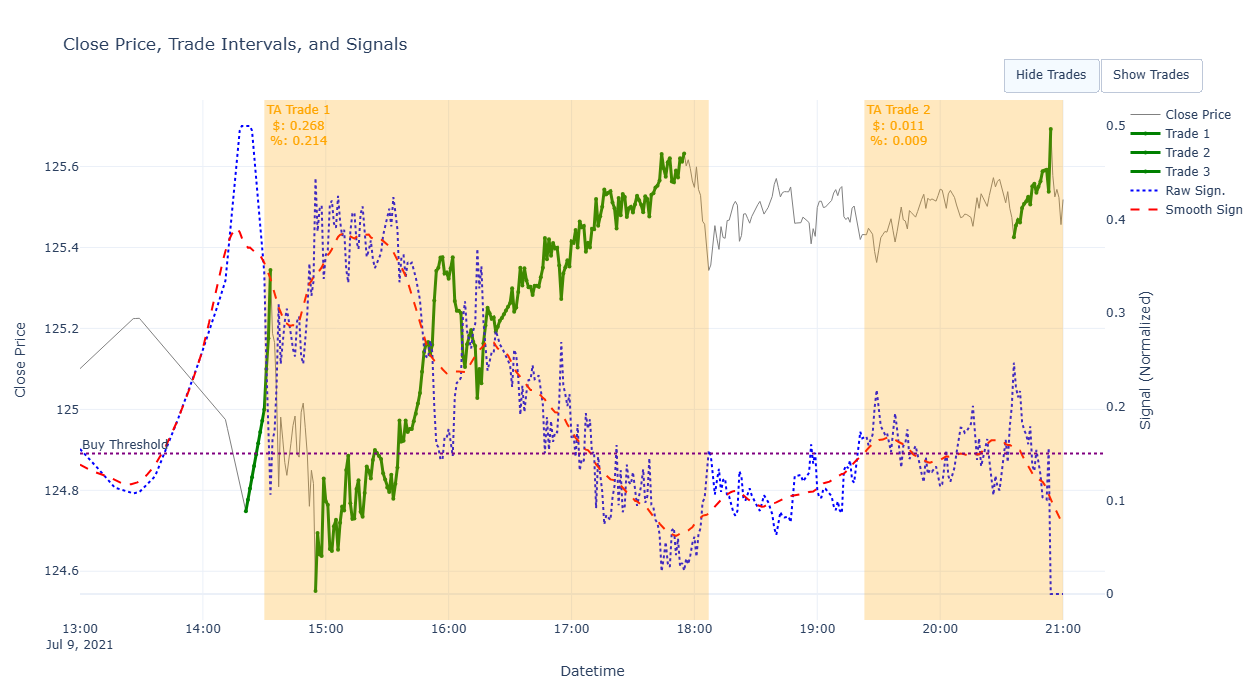

 Daily Performance:
   Final Net Value ($): 0.218
   Buy & Hold Gain ($): 0.381
   Strategy Profit Difference ($): -0.163
   Final Net Return (%): 0.174
   Buy & Hold Return (%): 0.305
   Strategy Improvement (%): -0.131
   Trade Gains ($): [np.float64(0.268), np.float64(0.011)]
   Trade Gains (%): [np.float64(0.214), np.float64(0.009)]

=== Processing trading day 2021-07-12 ===


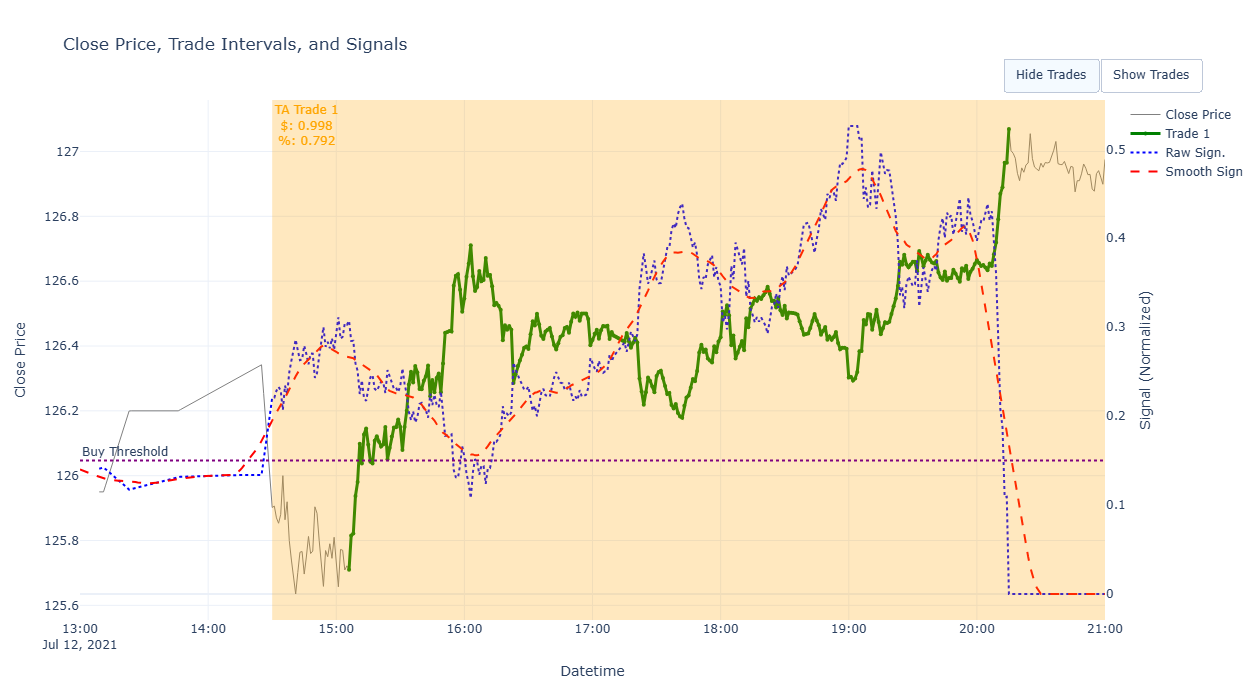

 Daily Performance:
   Final Net Value ($): 0.921
   Buy & Hold Gain ($): 0.921
   Strategy Profit Difference ($): -0.0
   Final Net Return (%): 0.731
   Buy & Hold Return (%): 0.732
   Strategy Improvement (%): -0.0
   Trade Gains ($): [np.float64(0.998)]
   Trade Gains (%): [np.float64(0.792)]

=== Processing trading day 2021-07-13 ===


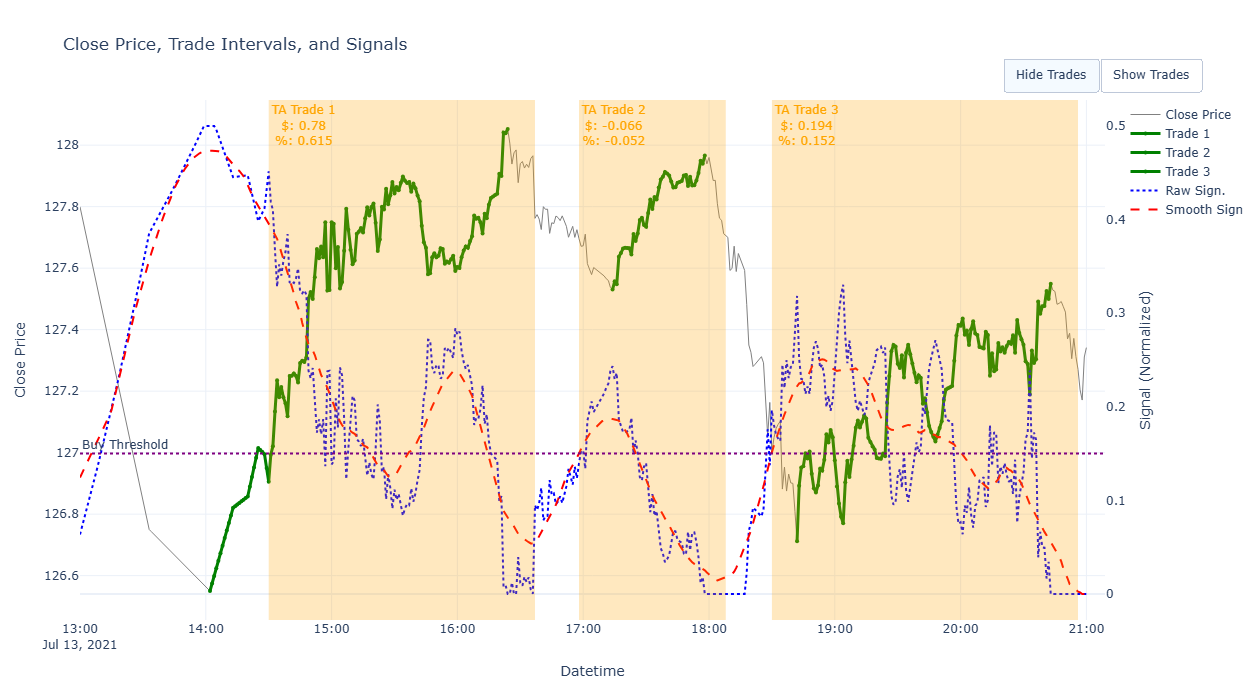

 Daily Performance:
   Final Net Value ($): 0.908
   Buy & Hold Gain ($): 0.329
   Strategy Profit Difference ($): 0.579
   Final Net Return (%): 0.715
   Buy & Hold Return (%): 0.26
   Strategy Improvement (%): 0.456
   Trade Gains ($): [np.float64(0.78), np.float64(-0.066), np.float64(0.194)]
   Trade Gains (%): [np.float64(0.615), np.float64(-0.052), np.float64(0.152)]

=== Processing trading day 2021-07-14 ===


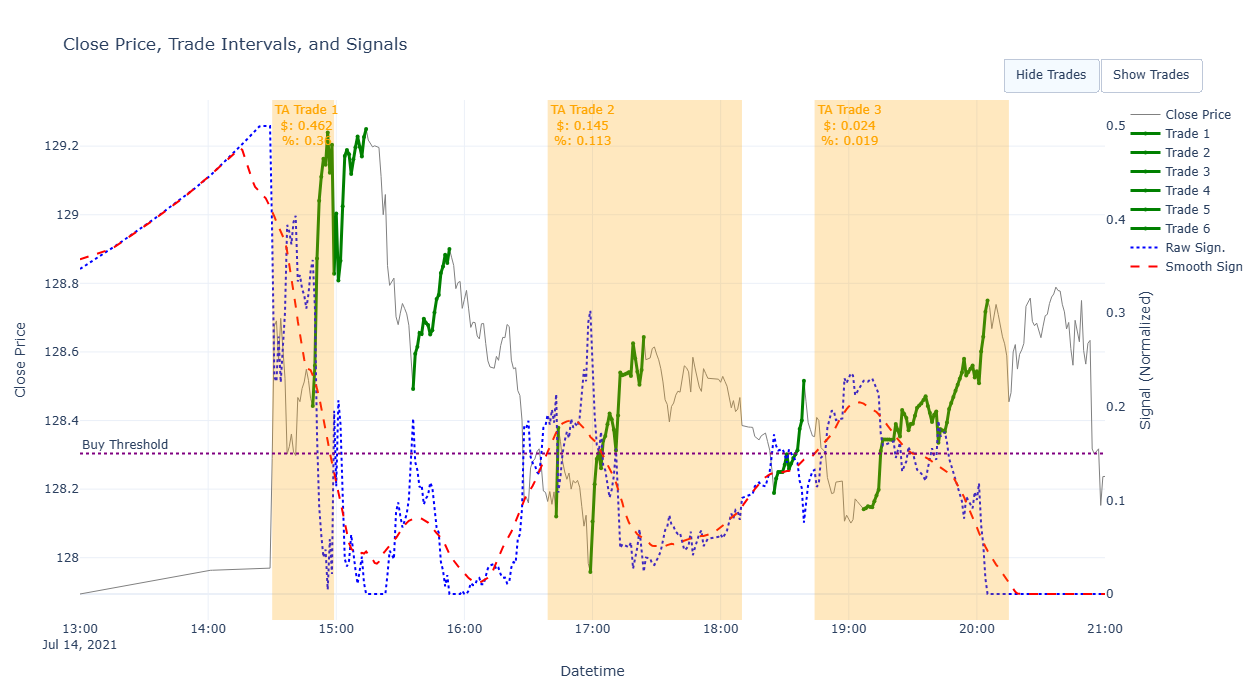

 Daily Performance:
   Final Net Value ($): 0.631
   Buy & Hold Gain ($): -0.13
   Strategy Profit Difference ($): 0.761
   Final Net Return (%): 0.492
   Buy & Hold Return (%): -0.101
   Strategy Improvement (%): 0.593
   Trade Gains ($): [np.float64(0.462), np.float64(0.145), np.float64(0.024)]
   Trade Gains (%): [np.float64(0.36), np.float64(0.113), np.float64(0.019)]

=== Processing trading day 2021-07-15 ===


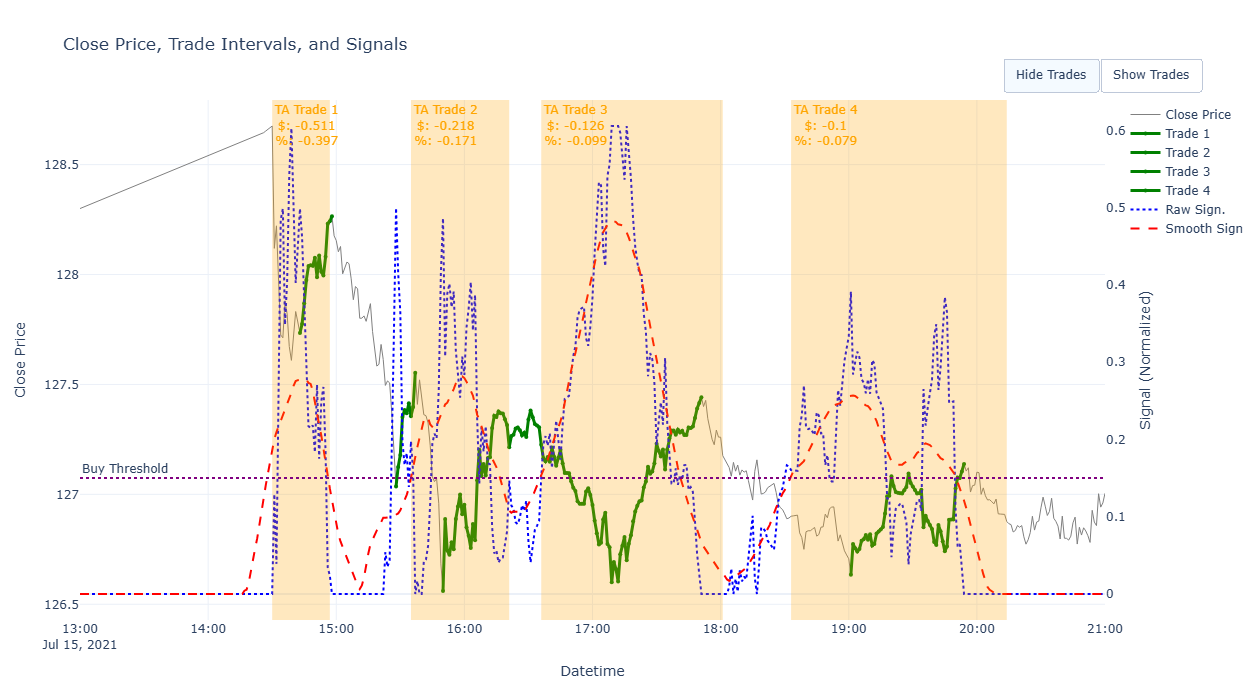

 Daily Performance:
   Final Net Value ($): -0.954
   Buy & Hold Gain ($): -1.791
   Strategy Profit Difference ($): 0.837
   Final Net Return (%): -0.741
   Buy & Hold Return (%): -1.392
   Strategy Improvement (%): 0.65
   Trade Gains ($): [np.float64(-0.511), np.float64(-0.218), np.float64(-0.126), np.float64(-0.1)]
   Trade Gains (%): [np.float64(-0.397), np.float64(-0.171), np.float64(-0.099), np.float64(-0.079)]

=== Processing trading day 2021-07-16 ===


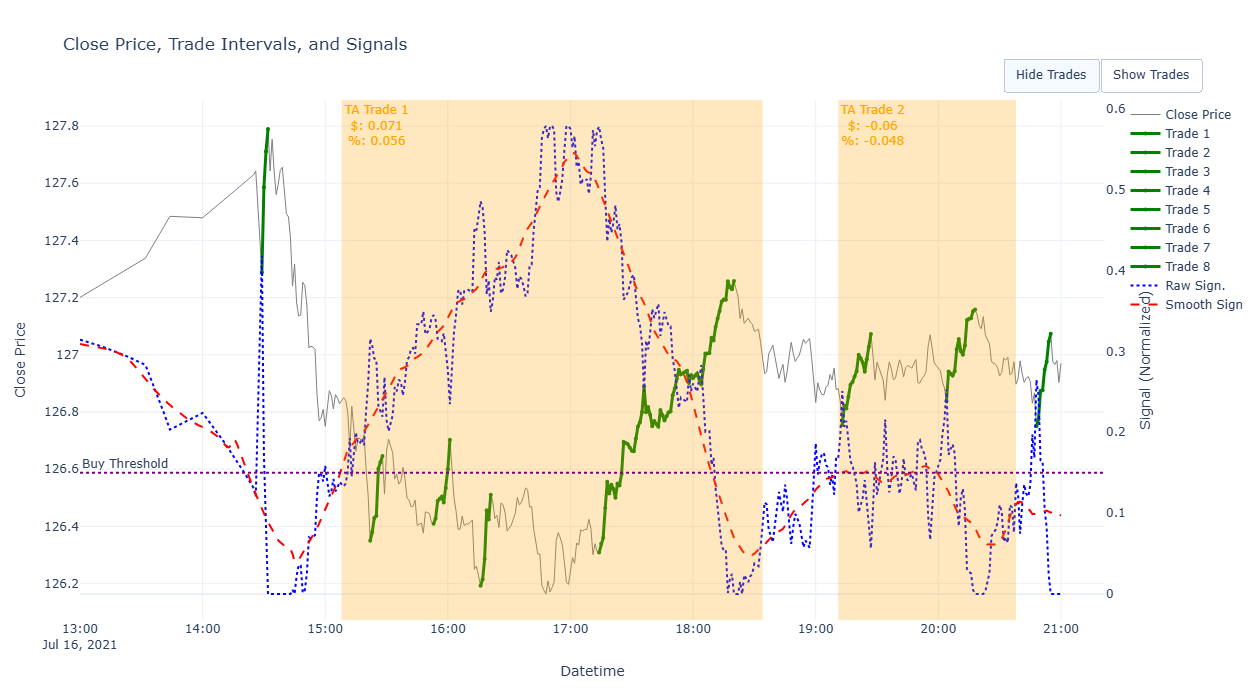

 Daily Performance:
   Final Net Value ($): 0.011
   Buy & Hold Gain ($): -0.759
   Strategy Profit Difference ($): 0.77
   Final Net Return (%): 0.009
   Buy & Hold Return (%): -0.594
   Strategy Improvement (%): 0.603
   Trade Gains ($): [np.float64(0.071), np.float64(-0.06)]
   Trade Gains (%): [np.float64(0.056), np.float64(-0.048)]

=== Processing trading day 2021-07-19 ===


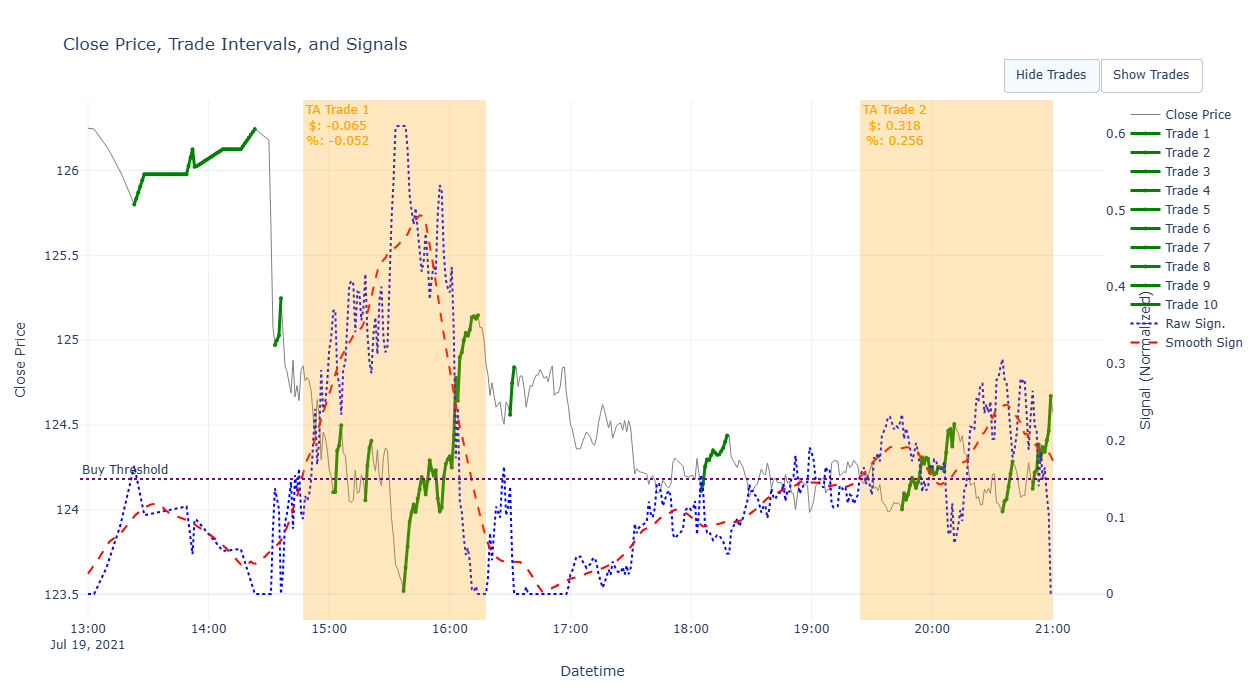

 Daily Performance:
   Final Net Value ($): 0.347
   Buy & Hold Gain ($): -1.583
   Strategy Profit Difference ($): 1.93
   Final Net Return (%): 0.275
   Buy & Hold Return (%): -1.254
   Strategy Improvement (%): 1.529
   Trade Gains ($): [np.float64(-0.065), np.float64(0.318)]
   Trade Gains (%): [np.float64(-0.052), np.float64(0.256)]

=== Processing trading day 2021-07-20 ===


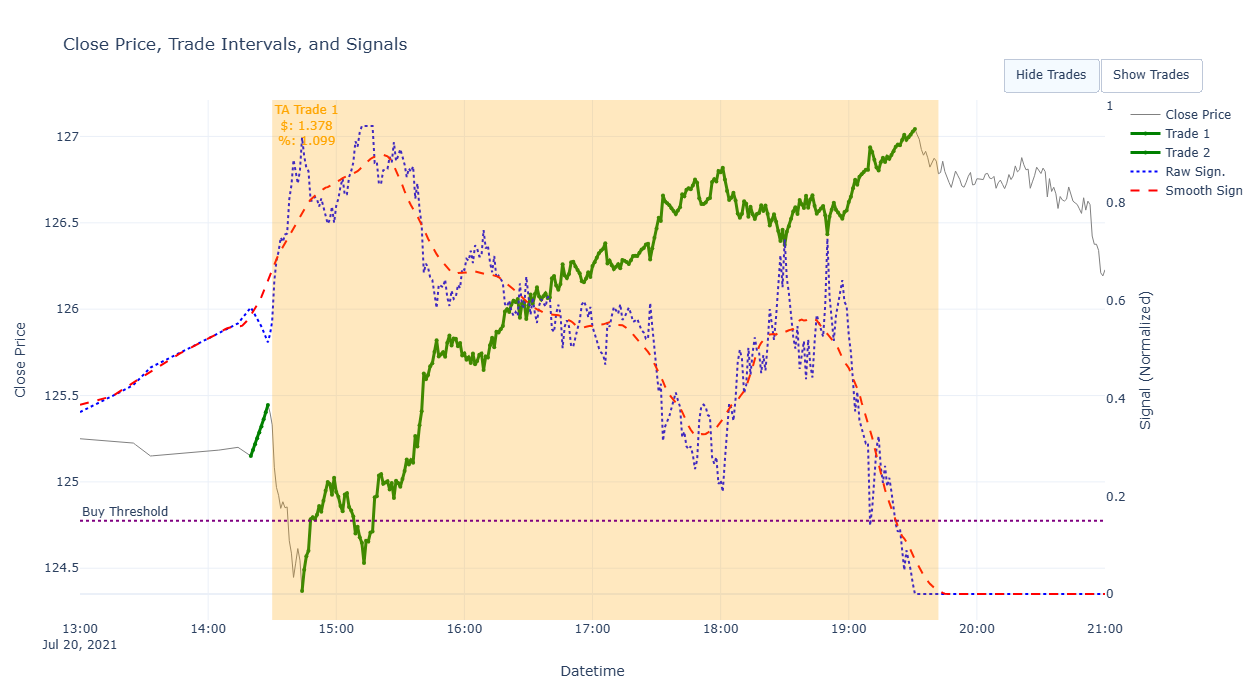

 Daily Performance:
   Final Net Value ($): 1.378
   Buy & Hold Gain ($): 0.787
   Strategy Profit Difference ($): 0.591
   Final Net Return (%): 1.099
   Buy & Hold Return (%): 0.628
   Strategy Improvement (%): 0.472
   Trade Gains ($): [np.float64(1.378)]
   Trade Gains (%): [np.float64(1.099)]

=== Processing trading day 2021-07-21 ===


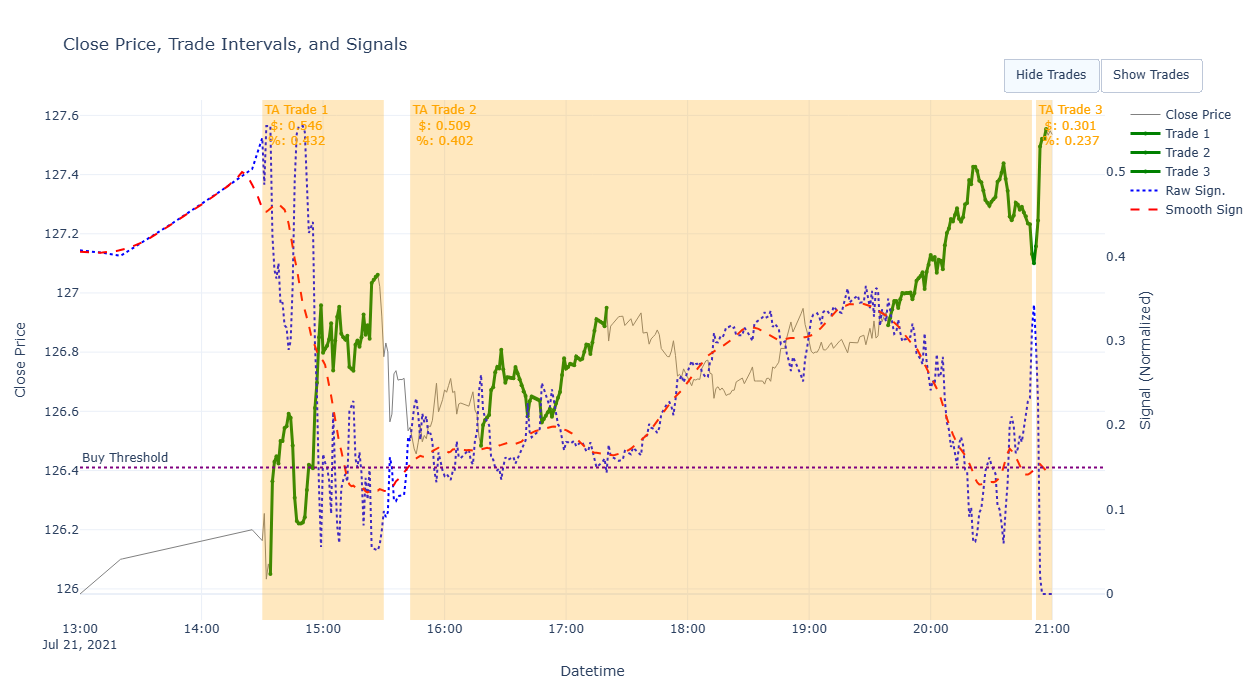

 Daily Performance:
   Final Net Value ($): 1.369
   Buy & Hold Gain ($): 1.309
   Strategy Profit Difference ($): 0.06
   Final Net Return (%): 1.085
   Buy & Hold Return (%): 1.037
   Strategy Improvement (%): 0.048
   Trade Gains ($): [np.float64(0.546), np.float64(0.509), np.float64(0.301)]
   Trade Gains (%): [np.float64(0.432), np.float64(0.402), np.float64(0.237)]

=== Processing trading day 2021-07-22 ===


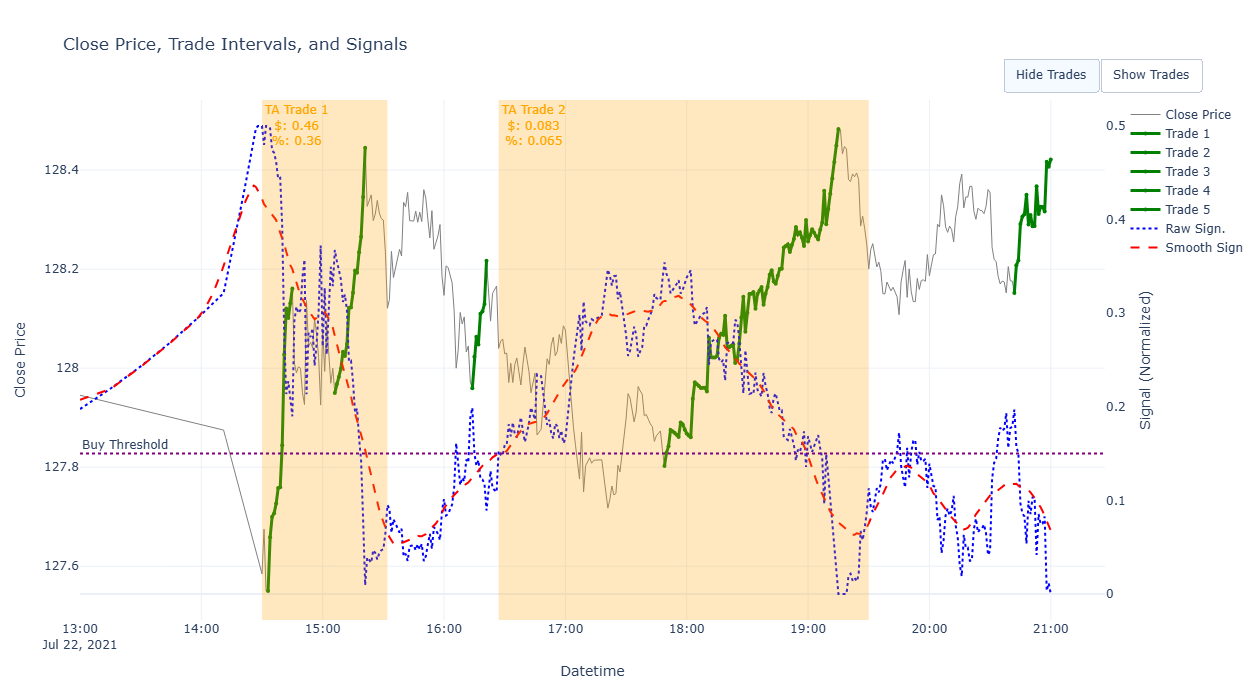

 Daily Performance:
   Final Net Value ($): 0.543
   Buy & Hold Gain ($): 0.746
   Strategy Profit Difference ($): -0.203
   Final Net Return (%): 0.425
   Buy & Hold Return (%): 0.584
   Strategy Improvement (%): -0.159
   Trade Gains ($): [np.float64(0.46), np.float64(0.083)]
   Trade Gains (%): [np.float64(0.36), np.float64(0.065)]

=== Processing trading day 2021-07-23 ===


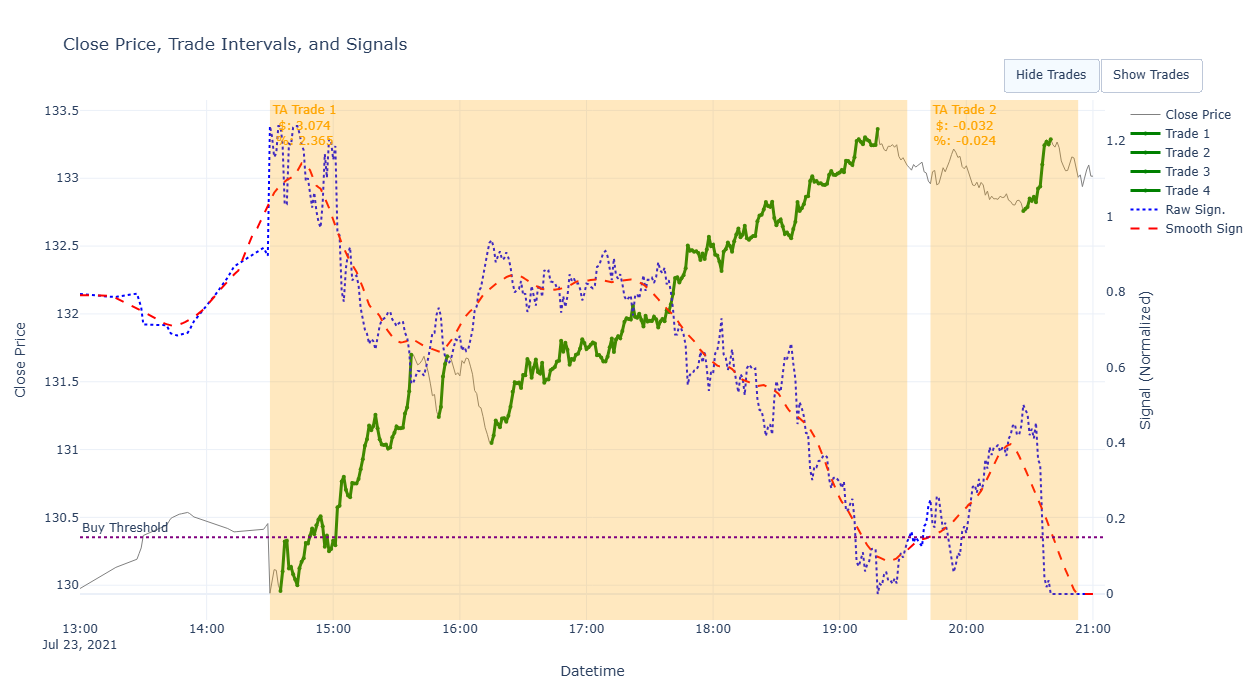

 Daily Performance:
   Final Net Value ($): 3.042
   Buy & Hold Gain ($): 2.996
   Strategy Profit Difference ($): 0.046
   Final Net Return (%): 2.34
   Buy & Hold Return (%): 2.305
   Strategy Improvement (%): 0.036
   Trade Gains ($): [np.float64(3.074), np.float64(-0.032)]
   Trade Gains (%): [np.float64(2.365), np.float64(-0.024)]

=== Processing trading day 2021-07-26 ===


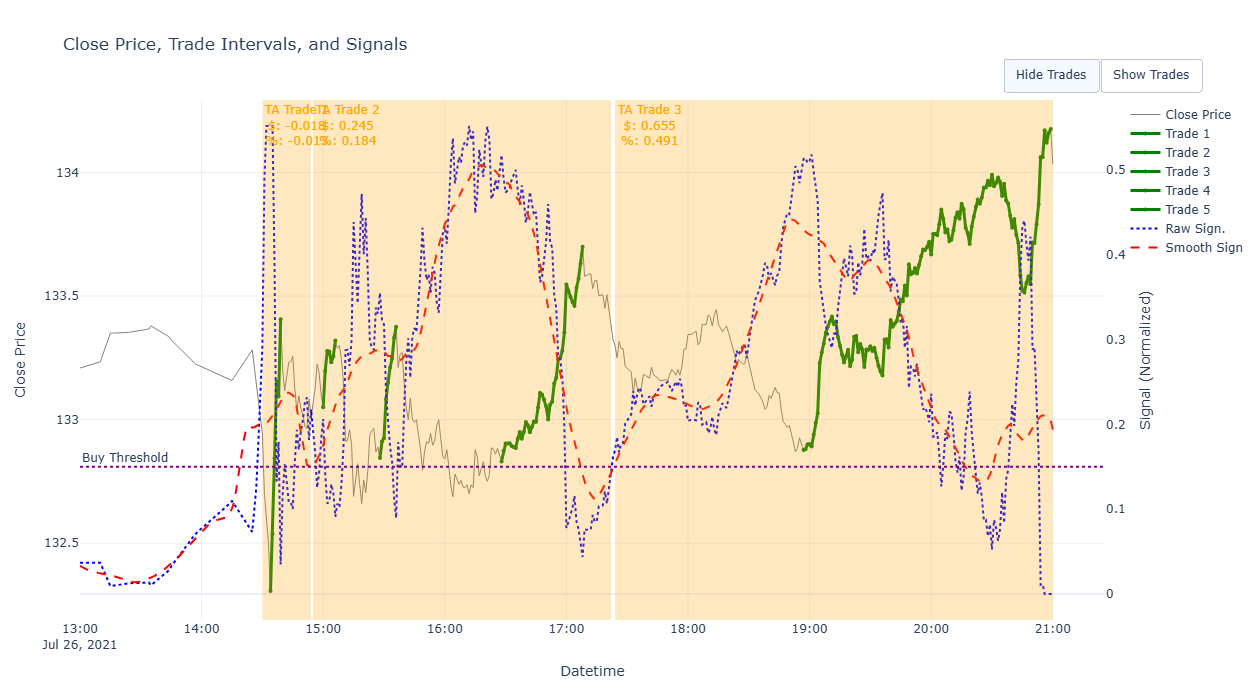

 Daily Performance:
   Final Net Value ($): 1.023
   Buy & Hold Gain ($): 1.154
   Strategy Profit Difference ($): -0.131
   Final Net Return (%): 0.769
   Buy & Hold Return (%): 0.868
   Strategy Improvement (%): -0.098
   Trade Gains ($): [np.float64(-0.018), np.float64(0.245), np.float64(0.655)]
   Trade Gains (%): [np.float64(-0.013), np.float64(0.184), np.float64(0.491)]

=== Processing trading day 2021-07-27 ===


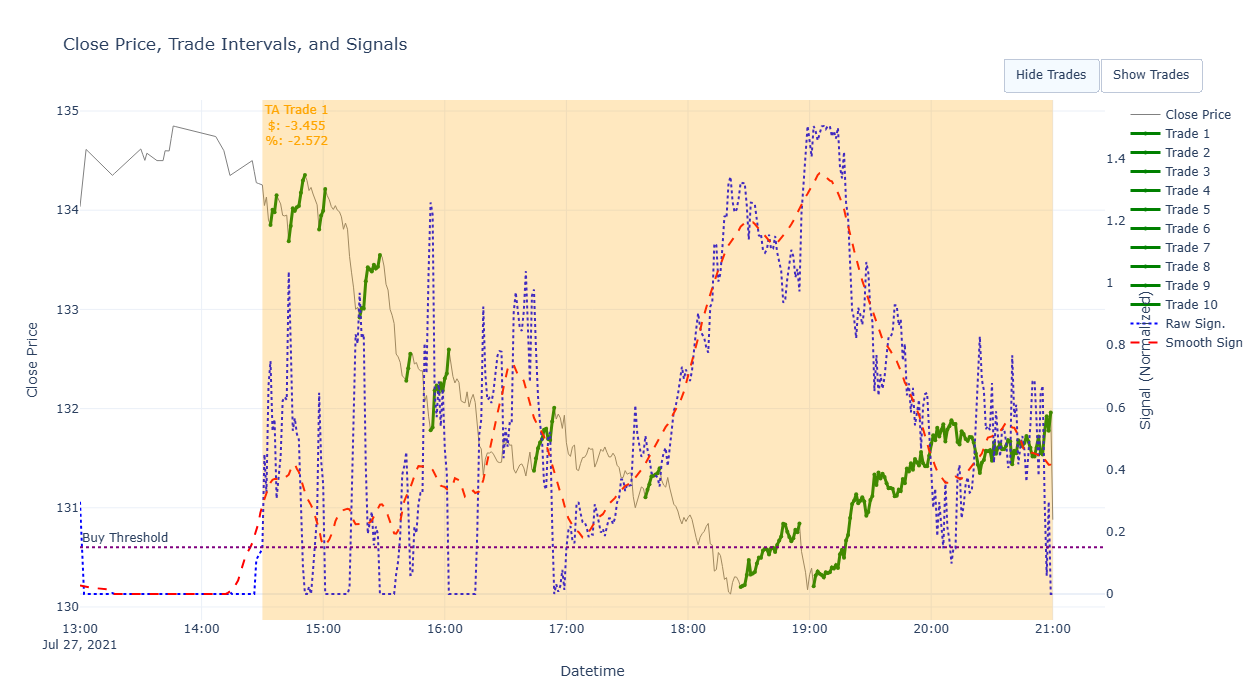

 Daily Performance:
   Final Net Value ($): -2.374
   Buy & Hold Gain ($): -2.374
   Strategy Profit Difference ($): 0.0
   Final Net Return (%): -1.768
   Buy & Hold Return (%): -1.768
   Strategy Improvement (%): 0.0
   Trade Gains ($): [np.float64(-3.455)]
   Trade Gains (%): [np.float64(-2.572)]

=== Processing trading day 2021-07-28 ===


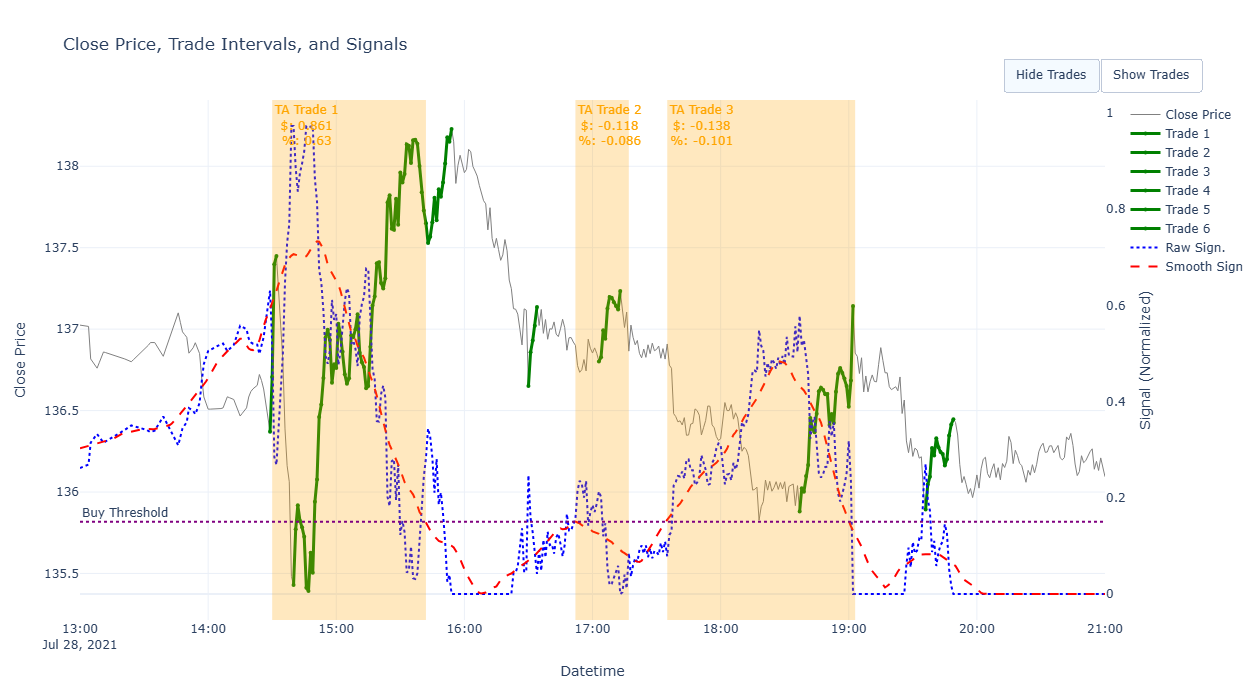

 Daily Performance:
   Final Net Value ($): 0.605
   Buy & Hold Gain ($): -0.643
   Strategy Profit Difference ($): 1.248
   Final Net Return (%): 0.442
   Buy & Hold Return (%): -0.47
   Strategy Improvement (%): 0.913
   Trade Gains ($): [np.float64(0.861), np.float64(-0.118), np.float64(-0.138)]
   Trade Gains (%): [np.float64(0.63), np.float64(-0.086), np.float64(-0.101)]

=== Processing trading day 2021-07-29 ===


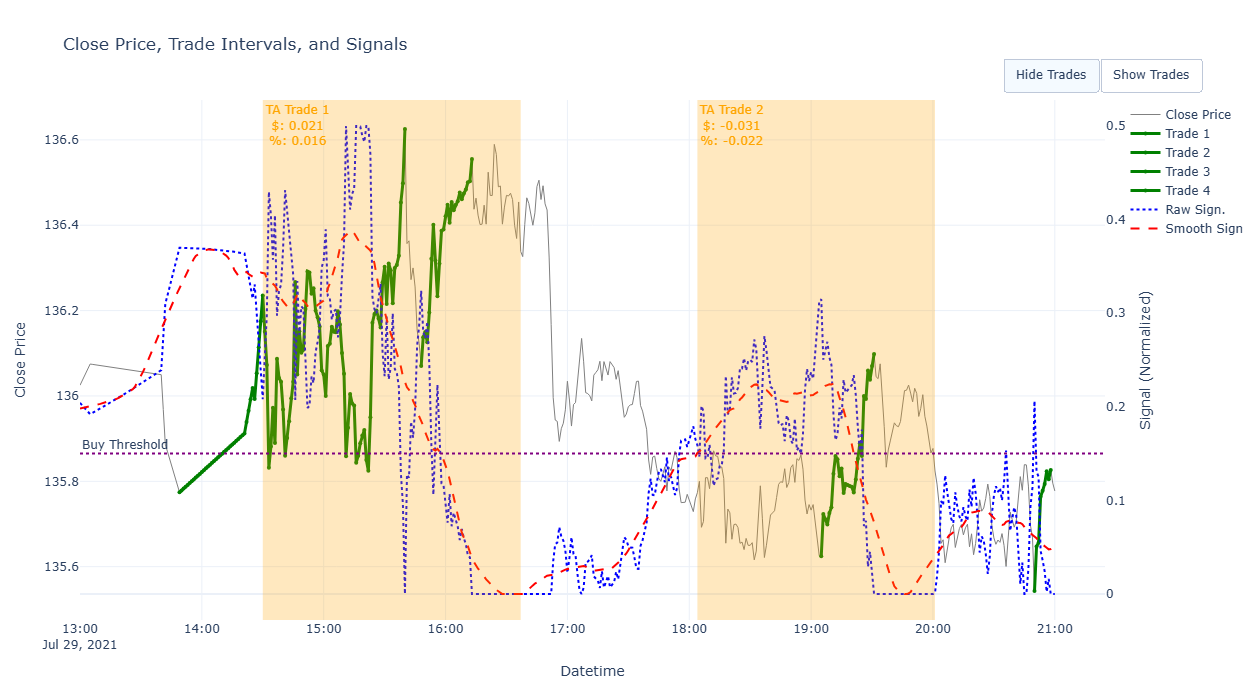

 Daily Performance:
   Final Net Value ($): -0.009
   Buy & Hold Gain ($): -0.521
   Strategy Profit Difference ($): 0.512
   Final Net Return (%): -0.007
   Buy & Hold Return (%): -0.383
   Strategy Improvement (%): 0.376
   Trade Gains ($): [np.float64(0.021), np.float64(-0.031)]
   Trade Gains (%): [np.float64(0.016), np.float64(-0.022)]

=== Processing trading day 2021-07-30 ===


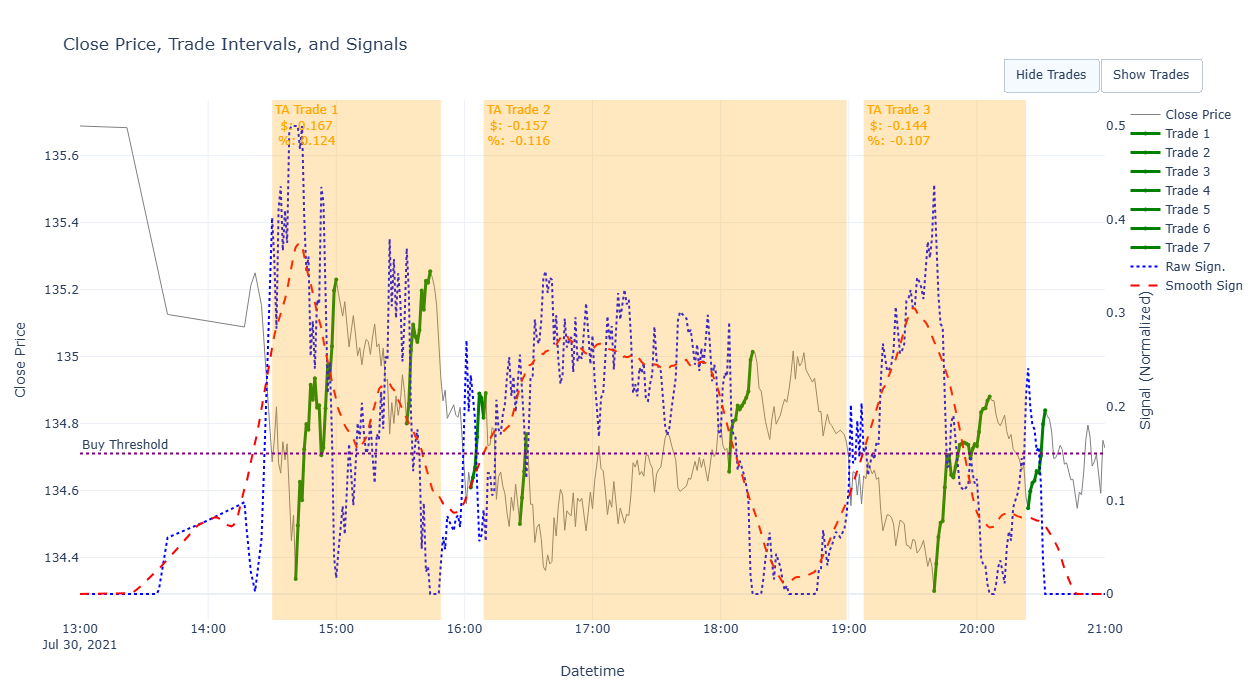

 Daily Performance:
   Final Net Value ($): -0.134
   Buy & Hold Gain ($): -0.016
   Strategy Profit Difference ($): -0.118
   Final Net Return (%): -0.099
   Buy & Hold Return (%): -0.012
   Strategy Improvement (%): -0.087
   Trade Gains ($): [np.float64(0.167), np.float64(-0.157), np.float64(-0.144)]
   Trade Gains (%): [np.float64(0.124), np.float64(-0.116), np.float64(-0.107)]

Final Summary for month 2021-07:
{'Buy & Hold Gain ($)': np.float64(3.05),
 'Buy & Hold Return (%)': np.float64(2.582),
 'Final Net Return (%)': np.float64(8.862),
 'Final Net Value ($)': np.float64(11.125),
 'Strategy Improvement (%)': np.float64(6.28),
 'Strategy Profit Difference ($)': np.float64(8.075),
 'Trade Gains ($)': '45 trades',
 'Trade Gains (%)': '45 trades'}


In [7]:
df_fin = saveDF_checkDAY(
                        df=df,
                        ticker=stockanalibs.ticker,
                        min_prof_thr=stockanalibs.min_prof_thr_man, 
                        max_down_prop=stockanalibs.max_down_prop_man, 
                        gain_tightening_factor=stockanalibs.gain_tightening_factor_man,
                        smooth_win_sig=stockanalibs.smooth_win_sig_man, 
                        pre_entry_decay=stockanalibs.pre_entry_decay_man, 
                        buy_threshold=stockanalibs.buy_threshold_man, 
                        trailing_stop_thresh=stockanalibs.trailing_stop_thresh_man,
                        merging_retracement_thr=stockanalibs.merging_retracement_thr_man, 
                        merging_time_gap_thr=stockanalibs.merging_time_gap_thr_man,
                        reference_gain=reference_gain,
                        date_to_check=date_to_check
                        )

df_fin